# Problema de Braquiterapia

## Simulación Monte Carlo

importar módulos para la simulación 

In [1]:
import LegPy as lpy
import numpy as np
import matplotlib.pyplot as plt

### Definir el medio y la geometría

In [2]:
# tamaño del medio (cilindro)
length = 14. # cm
width = 14. # cm diametro
nz, nr = 112, 56 # intervalos en z y r
medium = lpy.Medium(name='Water') # otros medios: 'Bone', 'Tissue', 'Muscle'
geometry = lpy.Geometry(name='cylinder', z = length, r = width/2., n_z = nz, n_r = nr) # Cylindrical voxelization

### Espectro de energía de la fuente

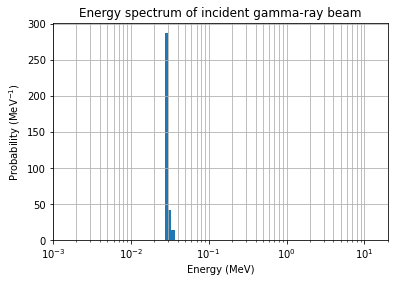

In [3]:
E = np.array([[0.02720, .406], [0.02747, .757], [0.03098, .202], [0.03171, .0439], [0.03549, .0668]] ) #125I 
#E = np.array([[0.00411, .086], [0.02964, .211], [0.029787, .389], [0.033562, .0363], 
#              [0.033624, .0702], [0.034419, .0213]] ) #131Cs
#E = np.array([[0.511, .80], [1.25, 0.20]]) # [[E1, I1], [E2, I2],....]

spectrum = lpy.Spectrum(name = 'multi_mono', E_w = E)
spectrum.plot(n_part = 100, n_bin = 100)

### Geometría de la fuente

In [4]:
x, y, z = 0., 0., 7. # cm posición del centro de la fuente
s_length = 0.45 # cm longitud de la semilla
s_width = 0.05 # cm radio de la semilla
beam = lpy.Beam(name = 'isotropic', length = s_length, r_width = s_width, p_in = np.array ([x, y, z]))

### Visualizar algunas trazas

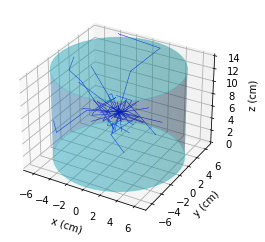

In [5]:
lpy.Plot_beam(medium, geometry, spectrum, beam)

### Realizar la simulación

In [7]:
n_ph = int(5.e6) # números de fotones a simular
output = lpy.MC(medium, geometry, spectrum, beam, n_part = n_ph, E_cut = 0.001)


The simulation has ended

Computing time per beam particle =  4.16e-04 seconds



## Comparación y validación de los resultados

Comparar el deposito de dosis calculado con el derivado del formalismo de TG43 AAPM

https://aapm.onlinelibrary.wiley.com/doi/epdf/10.1118/1.1646040

#### Formalismo

Aproximación 2D
\begin{equation}
    \dot D(r) = S_K \Lambda \frac{G_L(r, \theta)}{G_L(r_0, \theta_0)}g_L(r)F(r, \theta)
\end{equation}

Aproximación 1D, distribución isótropa, fuente puntual
\begin{equation}
    \dot D(r) = S_K \Lambda \frac{G_L(r, \theta_0)}{G_L(r_0, \theta_0)}g_L(r)\phi_{an}(r)
\end{equation}

donde en ambas aproximaciones 
\begin{equation}
G_L(r, \theta)= \left\{ \begin{array}{lcc}
                             \frac{\beta}{Lr\sin(\theta)} & si & \theta \neq 0 \\
                             \frac{1}{r^2-L^2/4} & si & \theta = 0 
                         \end{array}
               \right.
\end{equation}

Para la fuente considerada su longitud efectiva es $L$ = 0.35 cm

Para poder calcular la distribución de tasa de dosis tenemos que calcular $\beta$ en función de $r$ y $\theta$, $\beta = \beta(r, \theta)$.

Por construcción de triángulos es inmediato ver que $\beta = \theta_2 - \theta_1$ y que se verifican las ecuaciones

\begin{equation}
    \theta_1 = \arctan\left( \frac{r \sin (\theta)}{r \cos (\theta) + L/2} \right)
\end{equation}

\begin{equation}
\theta_2 = \left\{ \begin{array}{lcc}
                       \arctan \left(\frac{r \sin(\theta)}{r \cos(\theta)-L/2}\right) & si & r \cos(\theta) > L/2 \\
                       \pi/2 & si & r \cos(\theta) = L/2 \\
                       \pi/2 + \arctan \left(\frac{L/2 + r \cos(\theta)}{r \sin(\theta)}\right) & si & r \cos(\theta) < L/2 
                   \end{array}
           \right.
\end{equation}

De donde obtendríamos $\beta = \beta(r, \theta)$

#### Validación

Calculamos la función $g_L(r)$ a partir del depósito relativo de energía 
\begin{equation}
  g_L(r) = \frac{\dot D(r)}{\dot D(r_0)}\frac{G_L(r_0, \theta_0)}{G_L(r, \theta_0)}
\end{equation}

Donde hemos tenido en cuenta que en la aproximación 2D $F(r, \theta_0) = 1$ 

### Instalar e importar algunos paquetes adicionales

In [8]:
import pandas as pd
import matplotlib as mpl

### Resultado de la simulación 

In [14]:
# si se usa el dataFrame generado en la simulación
Ddf = output.Edep_to_df()

Obtenemos las coordenadas y los valores de deposito de energía.

Seleccionar el deposito de energía en función de la distancia radial en el plano perpedicular a la fuente y que la bisecciona.

In [100]:
X = np.array(Ddf.columns)
Y = np.array(Ddf.index)
Z = Ddf.to_numpy()
Dr = Z[55]

Obtener el factor de normalización del depósito de dosis. De acuerdo al formalismo de la AAPM se normaliza a un 1 cm de la fuente.

In [16]:
Drn = Dr[7] + (Dr[8] - Dr[7])/(X[8] - X[7])*(1.-X[7])

### Cálculos TG43 para la fuente Bebig de I125

In [81]:
from scipy.interpolate import interp1d as cspline, interp2d

Unidades: longitudes en cm y ángulos en grados sexagesimales

Constante con la longitud efectiva de la fuente

In [17]:
L = 0.35

Constantes con las coordendas del punto de referencia

In [18]:
r0, theta0 = 1, 90

Constante para el cambio de grados sexagesimales a radianes

In [19]:
d_r = np.pi/180

Definimos la función $\beta(r, \theta)$

In [153]:
def beta(r, theta):
    if r * np.cos(theta) > L/2:
        return np.arctan(r*np.sin(theta)/(r*np.cos(theta)-L/2)) - np.arctan(r*np.sin(theta)/(r*np.cos(theta)+L/2))
    elif r * np.cos(theta) == L/2:
        return np.pi/2 - np.arctan(r*np.sin(theta)/(r*np.cos(theta)+L/2))
    else:
        return (np.pi/2 + np.arctan((L/2-r*np.cos(theta))/r/np.sin(theta)) 
                - np.arctan(r*np.sin(theta)/(r*np.cos(theta)+L/2)))

Definimos la función $G_L(r, \theta)$

In [21]:
def G_L(r, theta):
    if theta == 0:
        return 1 / (r**2 - L**2/4)
    else:
        return beta(r, theta)/(L * r * np.sin(theta))

Definimos la constante de normalización de la función de geometría $G_L(r_0, \theta_0)$

In [22]:
G_L_r0_theta0 = G_L(r0, theta0 * d_r)

Vectorizamos la función para facilitar los cálculos posteriores

In [23]:
G_L_v = np.vectorize(G_L)

Leemos los datos tabulados de la AAPM

Función de dosis radial $g_L$, función de anisotropía $\phi_{an}(r)$ para la aproximación 1D y función $F(r, \theta)$ para el tratamiento 2D

In [32]:
gdf = pd.read_excel('FuncionesDosimetricas.xlsx', sheet_name='g')
phiandf = pd.read_excel('FuncionesDosimetricas.xlsx', sheet_name='phi_an')
Fdf = pd.read_excel('FuncionesDosimetricas.xlsx', sheet_name='F')

Comparar la función radial calculada con LegPy y la aproximación analítica

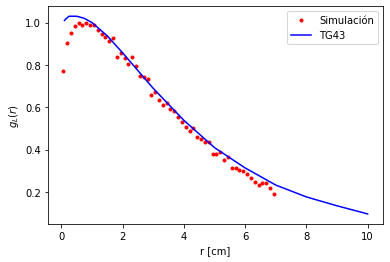

In [26]:
fig, ax = plt.subplots()
ax.plot(X, Dr/Drn * G_L_r0_theta0/G_L_v(X, 90*d_r), 'r.')
ax.plot(gdf.r, gdf.Lineal, 'b-')

ax.set_xlabel('r [cm]')
ax.set_ylabel('$g_L(r)$')

ax.legend(['Simulación', 'TG43'])
plt.show()

Mapa de isodosis (isodepósito de dosis) calculado a partir de la simulación

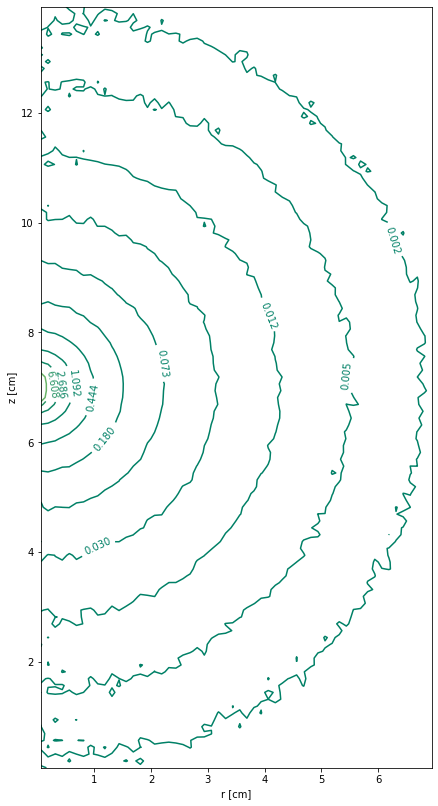

In [27]:
fig, ax = plt.subplots(figsize=(7, 14))
levels = np.geomspace(0.002, 40., 12)
CS = ax.contour(X, Y, Z, levels=levels, cmap='summer')
ax.clabel(CS, levels, fmt='%4.3f')
ax.set_xlabel('r [cm]')
ax.set_ylabel('z [cm]')
plt.show()

Definimos la función $G_L(r, \theta)$

In [28]:
def G_L(r, theta):
    if theta == 0:
        return 1 / (r**2 - L**2/4)
    else:
        return beta(r, theta)/(L * r * np.sin(theta))

Definimos la constante de normalización de la función de geometría $G_L(r_0, \theta_0)$

In [29]:
G_L_r0_theta0 = G_L(r0, theta0 * d_r)

Vectorizamos la función para facilitar los cálculos posteriores

In [30]:
G_L_v = np.vectorize(G_L)

Definimos la función que devuelve el valor de la tabla para la dosis radial

In [33]:
def g_L(r):
    return gdf.loc[gdf['r']==r]['Lineal'].values[0]

La vectorizamos

In [34]:
g_L_v = np.vectorize(g_L)

Definimos la función que devuelve el valor de la tabla para la función de anisotropía 1D $\phi_{an}(r)$

In [35]:
def phi_an(r):
    return phiandf.loc[phiandf['r']==r]['phi'].values[0]

La vectorizamos

In [36]:
phi_an_v = np.vectorize(phi_an)

Definimos la función que devuelve el valor de la tabla para la función de anisotropía 2D $F(r, \theta)$

In [83]:
def F(r, theta):
    theta = abs(theta)
    return Fdf.loc[Fdf['theta']==theta][r].values[0]

La vectorizamos

In [86]:
F_v = np.vectorize(F)

Generamos el gráfico con la distribución espacial de la tasa de dosis

Definimos los vectores con el muestreo de $r$ y $\theta$

In [39]:
rv = np.array([0.25, 0.5, 1., 2., 3.,  4., 5., 7.])
rv

array([0.25, 0.5 , 1.  , 2.  , 3.  , 4.  , 5.  , 7.  ])

In [76]:
thetav = Fdf['theta'].values
thetav

array([ 0,  5, 10, 20, 30, 40, 50, 60, 70, 80])

Extendemos thetav con los valores negativos

In [77]:
minusthetav = -thetav
thetas = thetav.tolist() + minusthetav[1:].tolist()
thetas.sort()
thetav = np.array(thetas)
thetav

array([-80, -70, -60, -50, -40, -30, -20, -10,  -5,   0,   5,  10,  20,
        30,  40,  50,  60,  70,  80])

In [78]:
R, Theta = np.meshgrid(rv, thetav * d_r)

In [79]:
R, ThetaDeg = np.meshgrid(rv, thetav)

Definimos la función de interpolación para la función $g_L$

In [84]:
g_Lf = cspline(rv, g_L_v(rv), kind='cubic', bounds_error=False, fill_value="extrapolate")

Definimos la función de interpolación para la función $F$

In [146]:
%%capture --no-display
Ff = interp2d(R, ThetaDeg, F_v(R, ThetaDeg), kind='cubic', bounds_error=False, fill_value=None)

La vectorizamos

In [88]:
Ffv = np.vectorize(Ff)

Definimos la función de interpolación para la función $\phi_{an}$

In [89]:
phi_anf = cspline(rv, phi_an_v(rv), kind='cubic', bounds_error=False, fill_value="extrapolate")

La vectorizamos

In [90]:
phi_anfv = np.vectorize(phi_anf)

### Aproximación 2D

Generamos el mallado cartesiano

In [91]:
X, Y = R * np.cos(Theta), R * np.sin(Theta)

Generamos el muestreo espacial de la tasa de dosis alrededor de la semilla

In [92]:
D_rate_2D = G_L_v(R, Theta) / G_L_r0_theta0 * g_L_v(R) * F_v(R, ThetaDeg)

#### Curvas de isovalores, igual tasa de dosis

Comparaamos la distribución calculada utilizando LegPy con las dos aproximaciones de la AAPM
.
Interpolamos las tablas de la AAPM para generar el gráfico de la distribución espacial de la tasa de dosis con una mejor resolución.

Calculamos primero un valor de renormalización para poder comparar ambas distribuciones en términos relativos.

Tomamos el punto $r = 1$, $\phi = 90^\circ$ como el punto de referencia 

In [150]:
def norm_val(S, Phi, Dr):
    Drn = Dr[7] + (Dr[8] - Dr[7])/(X[8] - X[7])*(1.-X[7])
    return G_L_v(S, Phi*d_r) / G_L_r0_theta0 * g_Lf(S) * phi_anfv(S)/Drn

knorm = norm_val(1, 0, Dr)

Comparación con la aproximación 1D

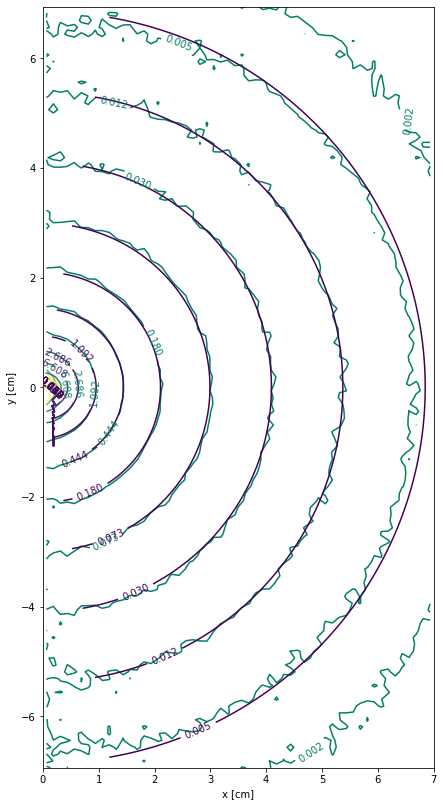

In [151]:
%%capture --no-display
sv, phiv = np.arange(0, 7.05, 0.1), np.arange(-80.0, 80.05, 1)
S, Phi = np.meshgrid(sv, phiv)
U, V = S * np.cos(Phi*d_r), S * np.sin(Phi*d_r)
D_rate_den_1D = G_L_v(S, Phi*d_r) / G_L_r0_theta0 * g_Lf(S) * phi_anfv(S)
fig, ax = plt.subplots(figsize=(7, 14))
levels = np.geomspace(0.002, 40., 12)
CSL = ax.contour(X, Y - 7, knorm * Z, levels=levels, cmap='summer')
ax.clabel(CSL, levels, fmt='%4.3f')
CS1D = ax.contour(U, V, D_rate_den_1D, levels=levels, cmap='viridis')
ax.clabel(CS1D, levels, fmt='%4.3f')
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
plt.show()

Comparación con la aproximación 2D

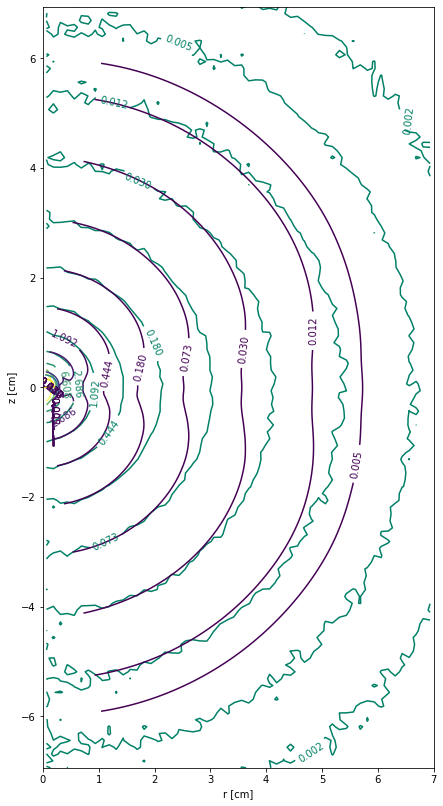

In [152]:
%%capture --no-display
sv, phiv = np.arange(0, 7.05, 0.1), np.arange(-80.0, 80.05, 1)
S, Phi = np.meshgrid(sv, phiv)
U, V = S * np.cos(Phi*d_r), S * np.sin(Phi*d_r)
D_rate_den_2D = G_L_v(S, Phi*d_r) / G_L_r0_theta0 * g_Lf(S) * Ffv(S, Phi)
fig, ax = plt.subplots(figsize=(7, 14))
levels = np.geomspace(0.002, 40., 12)
CSL = ax.contour(X, Y - 7, Z * knorm, levels=levels, cmap='summer')
ax.clabel(CSL, levels, fmt='%4.3f')
CSA = ax.contour(U, V, D_rate_den_2D, levels=levels)
ax.clabel(CSA, levels, fmt='%4.3f')
ax.set_xlabel('r [cm]')
ax.set_ylabel('z [cm]')
plt.show()